**Machine Learning Basic Principles 2018 - Data Analysis Project Report**

*All the text in italics is instructions for filling the template - remove when writing the project report!*

# *Title* 

*Title should be concise and informative, describes the approach to solve the problem. Some good titles from previous years:*

*- Comparing extreme learning machines and naive bayes’ classifier in spam detection*

*- Using linear discriminant analysis in spam detection*

*Some not-so-good titles:*

*- Bayesian spam filtering with extras*

*- Two-component classifier for spam detection*

*- CS-E3210 Term Project, final report*




## Abstract

*Precise summary of the whole report, previews the contents and results. Must be a single paragraph between 100 and 200 words.*



## 1. Introduction

*Background, problem statement, motivation, many references, description of
contents. Introduces the reader to the topic and the broad context within which your
research/project fits*

*- What do you hope to learn from the project?*
*- What question is being addressed?*
*- Why is this task important? (motivation)*

*Keep it short (half to 1 page).*



## 2. Data analysis

*Briefly describe data (class distribution, dimensionality) and how will it affect
classification. Visualize the data. Don’t focus too much on the meaning of the features,
unless you want to.*

*- Include histograms showing class distribution.*



In [40]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC


In [41]:
# Load the data and cleanup
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")
train_labels = pd.read_csv("train_labels.csv")




(4362, 264) (6543, 264) (4362, 1)


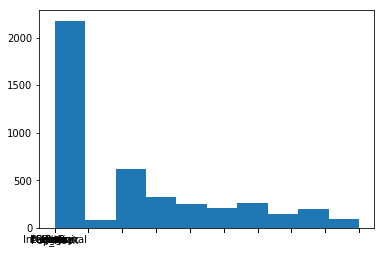

In [63]:
#Analysis of the input data
print(train_data.shape, test_data.shape, train_labels.shape)



#Histogram of class distribution

class_labels = ['Pop_Rock', 'Electronic', 'Rap', 'Jazz', 'Latin', 'RnB', 'International', 'Country', 'Reggae', 'Blues']

plt.hist(train_labels)
plt.xticks(train_labels, class_labels)
plt.show()

## 3. Methods and experiments

*- Explain your whole approach (you can include a block diagram showing the steps in your process).* 

*- What methods/algorithms, why were the methods chosen. *

*- What evaluation methodology (cross CV, etc.).*



In [57]:
train_labels.values.ravel()

array([1, 1, 1, ..., 2, 5, 2])

In [64]:
# Trials with ML algorithms
#Try 1, LinearRegression
classifier_1 = LinearRegression().fit(train_data, train_labels)
classifier_1.score(train_data, train_labels)
classifier_1.predict(test_data)

#Try 2, SVM
classifier_2 = SVC(gamma='auto')
classifier_2.fit(train_data, train_labels.values.ravel())
classifier_2.score(train_data, train_labels.values.ravel())



1.0

## 4. Results

*Summarize the results of the experiments without discussing their implications.*

*- Include both performance measures (accuracy and LogLoss).*

*- How does it perform on kaggle compared to the train data.*

*- Include a confusion matrix.*



In [5]:
#Confusion matrix ...

## 5. Discussion/Conclusions

*Interpret and explain your results *

*- Discuss the relevance of the performance measures (accuracy and LogLoss) for
imbalanced multiclass datasets. *

*- How the results relate to the literature. *

*- Suggestions for future research/improvement. *

*- Did the study answer your questions? *



## 6. References

*List of all the references cited in the document*

## Appendix
*Any additional material needed to complete the report can be included here. For example, if you want to keep  additional source code, additional images or plots, mathematical derivations, etc. The content should be relevant to the report and should help explain or visualize something mentioned earlier. **You can remove the whole Appendix section if there is no need for it.** *